# Cross-validation: evaluating estimator performance

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake:- 

A model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test.

Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally. Here is a flowchart of typical cross validation workflow in model training. The best parameters can be determined by grid search techniques.

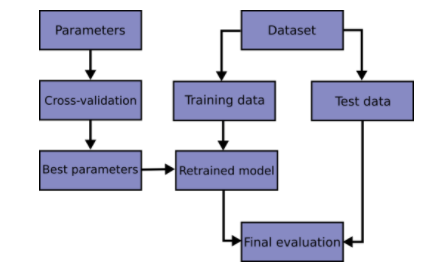

train_test_split :- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

In [2]:
X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

We can now quickly sample a training set while holding out 40% of the data for testing (evaluating) our classifier:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [4]:
X_train.shape, y_train.shape

((90, 4), (90,))

In [5]:
X_test.shape, y_test.shape

((60, 4), (60,))

In [6]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

In [7]:
clf

SVC(C=1, kernel='linear')

In [8]:
clf.score(X_test, y_test)

0.9666666666666667

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

A model is trained using (k-1) of the folds as training data;

The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

# Computing cross-validated metrics

The simplest way to use cross-validation is to call the cross_val_score helper function on the estimator and the dataset.

The following example demonstrates how to estimate the accuracy of a linear kernel support vector machine on the iris dataset by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time)

In [9]:
from sklearn.model_selection import cross_val_score

In [14]:
clf1 = svm.SVC(kernel='linear', C=1, random_state=42)

In [15]:
scores = cross_val_score(clf1, X, y, cv=5)

In [16]:
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [17]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change this by using the scoring parameter

In [18]:
from sklearn import metrics

In [19]:
scores = cross_val_score(clf1, X, y, cv=5, scoring='f1_macro')

In [20]:
scores


array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

See The scoring parameter: defining model evaluation rules for details. In the case of the Iris dataset, the samples are balanced across target classes hence the accuracy and the F1-score are almost equal.

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

It is also possible to use other cross validation strategies by passing a cross validation iterator instead, for instance

In [21]:
from sklearn.model_selection import ShuffleSplit

In [22]:
n_samples = X.shape[0]

In [23]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

In [24]:
cross_val_score(clf1, X, y, cv=cv)

array([0.97777778, 0.97777778, 1.        , 0.95555556, 1.        ])

Another option is to use an iterable yielding (train, test) splits as arrays of indices, for example:

In [25]:
def custom_cv_2folds(X):
    n = X.shape[0]
    i = 1
    while i <= 2:
        idx = np.arange(n * (i - 1) / 2, n * i / 2, dtype=int)
        yield idx, idx
        i += 1


In [26]:
custom_cv = custom_cv_2folds(X)
cross_val_score(clf1, X, y, cv=custom_cv)


array([1.        , 0.97333333])